In [1]:
import pandas as pd
import numpy as np

PATH = '/home/kai/data/kaggle/homecredit/'
train = pd.read_csv(PATH + 'application_train.csv')
print('train')
test = pd.read_csv(PATH + 'application_test.csv')
print('test')
bureau = pd.read_csv(PATH + 'bureau.csv')
print('bureau')
# prev = pd.read_csv(PATH + 'previous_application.csv')
# print('previous')
bb = pd.read_csv(PATH + 'bureau_balance.csv')
print('bureau_balance')
df = pd.concat([train[['SK_ID_CURR']], test[['SK_ID_CURR']]])
print('concat')

train
test
bureau
bureau_balance
concat


In [2]:
import pandas as pd
import os
import gc
import numpy as np
from sklearn.linear_model import LinearRegression

def _set_type(series, dtype):
    _max, _min = max(series), min(series)
    if dtype == 'uint':
        if _max <= 255: return np.uint8
        elif _max <= 65535: return np.uint16
        elif _max <= 4294967295: return np.uint32
        else: return np.uint64
    elif dtype == 'int':
        if _min >= -128 and _max <= 127: return np.int8
        elif _min >=-32768 and _max <= 32767: return np.int16
        elif _min >= -2147483648 and _max <= 2147483647: return np.int32
        else: return np.int64
    elif dtype == 'float':
        if max(abs(_min), _max) <= 3.4028235e+38: return np.float32
        else: return np.float64

def split_categorical_feature(df, group_col, calc_col):
    tmp_df = pd.concat([df[group_col], pd.get_dummies(df[calc_col], prefix=calc_col)], axis=1).groupby(by=group_col).sum().reset_index()
    dtype = {x: _set_type(tmp_df[x], 'uint') for x in tmp_df.columns if x != group_col}
    for x in tmp_df:
        if x in df.columns:
            dtype[x] = df[x].dtype
    return tmp_df.astype(dtype)

def score(df, group_col, calc_col, time_col, score_map, table_name):
    total = list(group_col)
    total.extend([calc_col, time_col])
    _df = df.sort_values('MONTHS_BALANCE').reset_index()
    _df[calc_col] = _df[calc_col].map(score_map)
    group = _df.groupby(by=group_col)
    _df[calc_col] = (group[calc_col].shift(1).fillna(0) + group[calc_col].shift(-1).fillna(0) + _df[calc_col]) ** 2 / np.exp(-(_df[time_col])**2/144/2)
    dtype = {x: df[x].dtype for x in group_col if x in df.columns}
    dtype[calc_col] = _set_type(_df[calc_col], 'float')
    __df = _df[[group_col, calc_col]].astype(dtype).rename(index=str, columns={calc_col: table_name + '_score'})
    del _df
    gc.collect()
    return __df

def count(df, group_col, calc_col, table_name):
    group = df[[group_col, calc_col]].groupby(by=group_col)[[calc_col]].count().reset_index()
    dtype = {x: df[x].dtype for x in group_col if x in df.columns}
    dtype[calc_col] = _set_type(group[calc_col], 'uint')
    _df = group.astype(dtype).rename(index=str, columns={calc_col: table_name + '_' + calc_col + '_count'})
    return _df

def linear(df, group_col, time_col, value_col, table_name):
    l = []
    for _, group in df[[group_col, time_col, value_col]].groupby(by=group_col):
        lg = LinearRegression()
        lg.fit(group[time_col], group[value_col])
        l.append([group.loc[0, group_col], lg.coef_[0][0], lg.intercept_[0]])
    return pd.DataFrame(l, columns=[group_col, table_name + '_' + 'lg_coef', table_name + '_' + 'lg_inte'])

def ratio_name(numerator, denominator): return numerator + '_' + denominator + '_ratio'

def ratio(df, numerator, denominator):
    return df[numerator] / df[denominator]

def markov_time_score(df_, group_col, calc_col, time_col):
    def _time(x): np.exp(-x**2/144/2)
    
    df = df_.sort_values('MONTHS_BALANCE').reset_index()
    mapp = {'0':0, '1':1, '2':2, '3':3, '4':4, '5':5, 'C':6, 'X':7}
    _df = df[calc_col].map(mapp)
    d = {}
    M = {}
    for i in range(df.shape[0]):
        if i % 2000000 == 0: print(i)
        key = df.loc[i, group_col]
        value = _df[i]
        if d.get(key) != None:
            M[key][d.get(key)][value] += 1 * _time(df.loc[i, time_col])
        else:
            M[key] = np.zeros((len(mapp), len(mapp)))
        d[key] = value
    del df, _df, d
    gc.collect()
    return M

In [3]:
m = {'C':0, 'X':0, '0':0, '1':1, '2':2, '3':3, '4':4, '5':5}
bb_score = score(bb, 'SK_ID_BUREAU', 'STATUS', 'MONTHS_BALANCE', m, 'bureau_balance')
bureau = bureau.merge(bb_score, on='SK_ID_BUREAU', how='left')
bureau.head(2)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,bureau_balance_score
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,NaN


In [5]:
bb_count = count(bb, 'SK_ID_BUREAU', 'STATUS', 'bb')
bureau = bureau.merge(bb_count, on='SK_ID_BUREAU', how='left')
bureau.head(2)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,bureau_balance_score,bb_STATUS_count
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,NaN,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,NaN,NaN


In [6]:
bureau[ratio_name('CNT_CREDIT_PROLONG', 'DAYS_CREDIT')] = ratio(bureau, 'CNT_CREDIT_PROLONG', 'DAYS_CREDIT')
print('CNT_CREDIT_PROLONG', 'DAYS_CREDIT')
bureau[ratio_name('AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM')] = ratio(bureau, 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM')
print('AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM')
bureau[ratio_name('AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM')] = ratio(bureau, 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM')
print('AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM')
bureau[ratio_name('AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_OVERDUE')] = ratio(bureau, 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_OVERDUE')
print('AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_OVERDUE')
bureau.columns

CNT_CREDIT_PROLONG DAYS_CREDIT
AMT_CREDIT_SUM_LIMIT AMT_CREDIT_SUM
AMT_CREDIT_SUM_DEBT AMT_CREDIT_SUM
AMT_CREDIT_SUM_DEBT AMT_CREDIT_SUM_OVERDUE


Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY', 'bureau_balance_score', 'bb_STATUS_count',
       'CNT_CREDIT_PROLONG_DAYS_CREDIT_ratio',
       'AMT_CREDIT_SUM_LIMIT_AMT_CREDIT_SUM_ratio',
       'AMT_CREDIT_SUM_DEBT_AMT_CREDIT_SUM_ratio',
       'AMT_CREDIT_SUM_DEBT_AMT_CREDIT_SUM_OVERDUE_ratio'],
      dtype='object')

In [7]:
cat_col_list = ['CREDIT_ACTIVE', 'CREDIT_TYPE']

for x in cat_col_list:
    print(x)
    df = df.merge(split_categorical_feature(bureau, 'SK_ID_CURR', x), on='SK_ID_CURR', how='left')
    gc.collect()
df.head(2)

CREDIT_ACTIVE
CREDIT_TYPE


,SK_ID_CURR,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Cash loan (non-earmarked),CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan
0,100002,20.0,0.0,90.0,0.0,0.0,0.0,0.0,52.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,1.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
def numerical_agg( df, gp_col, agg_col, extrafunc_list = None):
    
    agg_list = ['max', 'min', 'std','mean']
    '''
    Possible extrafunc_list: ['sum','median','two_minus_one_third','positive_count', 'negative_count','standard_error', 'trimmed_mean_10_pct', 'trimmed_mean_25_pct','normed_std', 'max_minus_min','one_third','two_third']
    '''
    if extrafunc_list:
        if 'one_third' in extrafunc_list:
            def one_third(series):
                return series.quantile(1/3)
            
        if 'two_third' in extrafunc_list:
            def two_third(series):
                return series.quantile(2/3)
            
        if 'max_minus_min' in extrafunc_list:
            def max_minus_min(series):
                return (series.max() - series.min())
        
        if 'two_minus_one_third' in extrafunc_list:
#             print('two_minus_one')
#             print('get two minus one')
            def two_minus_one_third(series):
                return(series.quantile(0.66666) - series.quantile(0.33333))
       
        if 'positive_count' in extrafunc_list:
#             print('get positive count')
            def positive_count(series):
                return pd.Series(series > 0).sum()

        if 'negative_count' in extrafunc_list:
#             print('get negative count')
            def negative_count(series):
                return pd.Series(series < 0).sum()

        if 'standard_error' in extrafunc_list:
#             print('get std-error')
            def standard_error(series):
                return series.std()/np.sqrt(len(series))

        if 'normed_std' in extrafunc_list:
#             print('get normed_std')
            def normed_std(series):
                return series.std()/series.mean()

        if 'trimmed_mean_10_pct' in extrafunc_list:
#             print('get_trimmed 10 pct')
            def trimmed_mean_10_pct(series):
                return stats.trim_mean(series.dropna(), 0.1)

        if 'trimmed_mean_25_pct' in extrafunc_list:
#             print('get_trimmed 25 pct')
            def trimmed_mean_25_pct(series):
                return stats.trim_mean(series.dropna(), 0.25)
        
        list_tocall = []
        for i in extrafunc_list:
            if i not in set(['sum', 'median']):
                list_tocall.append(eval(i))
            
    if extrafunc_list != None:   
        agg_list.extend(list_tocall)
    
    _df = df.groupby(gp_col).agg({agg_col:agg_list})
    columns = []
    for pre in _df.columns.levels[0]:
        for middle in _df.columns.levels[1]:
            columns.append('bureau_%s_%s' %(pre,middle))
    _df.columns = columns
    
    return _df.reset_index()

In [9]:
num_col_list = ['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE','AMT_CREDIT_MAX_OVERDUE','AMT_CREDIT_SUM',
                'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE',
                'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY', 'bureau_balance_score', 'CNT_CREDIT_PROLONG_DAYS_CREDIT_ratio',
                'AMT_CREDIT_SUM_LIMIT_AMT_CREDIT_SUM_ratio', 'AMT_CREDIT_SUM_DEBT_AMT_CREDIT_SUM_ratio',
                'AMT_CREDIT_SUM_DEBT_AMT_CREDIT_SUM_OVERDUE_ratio', 'bb_STATUS_count']

for x in num_col_list:
    print(x)
    df = df.merge(numerical_agg(bureau, 'SK_ID_CURR', x), on='SK_ID_CURR', how='left')
    gc.collect()
df.head(2)

DAYS_CREDIT
CREDIT_DAY_OVERDUE
DAYS_CREDIT_ENDDATE
AMT_CREDIT_MAX_OVERDUE
AMT_CREDIT_SUM
AMT_CREDIT_SUM_DEBT
AMT_CREDIT_SUM_LIMIT
AMT_CREDIT_SUM_OVERDUE
DAYS_CREDIT_UPDATE
AMT_ANNUITY
bureau_balance_score
CNT_CREDIT_PROLONG_DAYS_CREDIT_ratio
AMT_CREDIT_SUM_LIMIT_AMT_CREDIT_SUM_ratio
AMT_CREDIT_SUM_DEBT_AMT_CREDIT_SUM_ratio
AMT_CREDIT_SUM_DEBT_AMT_CREDIT_SUM_OVERDUE_ratio
bb_STATUS_count


,SK_ID_CURR,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Cash loan (non-earmarked),CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,...,bureau_AMT_CREDIT_SUM_DEBT_AMT_CREDIT_SUM_ratio_std,bureau_AMT_CREDIT_SUM_DEBT_AMT_CREDIT_SUM_ratio_mean,bureau_AMT_CREDIT_SUM_DEBT_AMT_CREDIT_SUM_OVERDUE_ratio_max,bureau_AMT_CREDIT_SUM_DEBT_AMT_CREDIT_SUM_OVERDUE_ratio_min,bureau_AMT_CREDIT_SUM_DEBT_AMT_CREDIT_SUM_OVERDUE_ratio_std,bureau_AMT_CREDIT_SUM_DEBT_AMT_CREDIT_SUM_OVERDUE_ratio_mean,bureau_bb_STATUS_count_max,bureau_bb_STATUS_count_min,bureau_bb_STATUS_count_std,bureau_bb_STATUS_count_mean
0,100002,20.0,0.0,90.0,0.0,0.0,0.0,0.0,52.0,58.0,...,0.270981,0.218472,inf,inf,NaN,inf,22.0,4.0,4.210317,16.327273
1,100003,1.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,2.0,...,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
train.merge(df, on='SK_ID_CURR', how='left').to_pickle(PATH + 'train_cleaned.pkl')
print('train')
test.merge(df, on='SK_ID_CURR', how='left').to_pickle(PATH + 'test_cleaned.pkl')
print('test')
gc.collect()

train
test


495

In [4]:
import pandas as pd
import numpy as np

PATH = '/home/kai/data/kaggle/homecredit/'

train_cleaned = pd.read_pickle(PATH + 'train_cleaned.pkl')
test_cleaned = pd.read_pickle(PATH + 'test_cleaned.pkl')
train_cleaned.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'bureau_AMT_CREDIT_SUM_DEBT_AMT_CREDIT_SUM_ratio_std',
       'bureau_AMT_CREDIT_SUM_DEBT_AMT_CREDIT_SUM_ratio_mean',
       'bureau_AMT_CREDIT_SUM_DEBT_AMT_CREDIT_SUM_OVERDUE_ratio_max',
       'bureau_AMT_CREDIT_SUM_DEBT_AMT_CREDIT_SUM_OVERDUE_ratio_min',
       'bureau_AMT_CREDIT_SUM_DEBT_AMT_CREDIT_SUM_OVERDUE_ratio_std',
       'bureau_AMT_CREDIT_SUM_DEBT_AMT_CREDIT_SUM_OVERDUE_ratio_mean',
       'bureau_bb_STATUS_count_max', 'bureau_bb_STATUS_count_min',
       'bureau_bb_STATUS_count_std', 'bureau_bb_STATUS_count_mean'],
      dtype='object', length=205)

In [5]:
from sklearn.preprocessing import LabelEncoder

categorical_feats = [
    'NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_TYPE_SUITE',
    'NAME_INCOME_TYPE','NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
    'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
    'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
    'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
    'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
    'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
    'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19',
    'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21','WEEKDAY_APPR_PROCESS_START', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 
    'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'
]

for x in categorical_feats:
    if train_cleaned[x].dtype == 'object':
        print(x)
        train_cleaned[x].fillna('na', inplace=True)
        test_cleaned[x].fillna('na', inplace=True)
        train_cleaned[x] = LabelEncoder().fit_transform(train_cleaned[x])
        test_cleaned[x] = LabelEncoder().fit_transform(test_cleaned[x])
    else:
        train_cleaned[x].fillna('na', inplace=True)
        test_cleaned[x].fillna('na', inplace=True)

NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
OCCUPATION_TYPE
ORGANIZATION_TYPE
WEEKDAY_APPR_PROCESS_START
FONDKAPREMONT_MODE
HOUSETYPE_MODE
WALLSMATERIAL_MODE
EMERGENCYSTATE_MODE


# light GBM

In [6]:
target = train_cleaned.pop('TARGET')
train_cleaned.pop('SK_ID_CURR')
print('done')

0         100002
1         100003
2         100004
3         100006
4         100007
5         100008
6         100009
7         100010
8         100011
9         100012
10        100014
11        100015
12        100016
13        100017
14        100018
15        100019
16        100020
17        100021
18        100022
19        100023
20        100024
21        100025
22        100026
23        100027
24        100029
25        100030
26        100031
27        100032
28        100033
29        100034
           ...  
307481    456225
307482    456226
307483    456227
307484    456228
307485    456229
307486    456230
307487    456231
307488    456232
307489    456233
307490    456234
307491    456235
307492    456236
307493    456237
307494    456238
307495    456239
307496    456240
307497    456241
307498    456242
307499    456243
307500    456244
307501    456245
307502    456246
307503    456247
307504    456248
307505    456249
307506    456251
307507    456252
307508    4562

In [21]:
print(train_cleaned.columns.values)

['NAME_CONTRACT_TYPE' 'CODE_GENDER' 'FLAG_OWN_CAR' 'FLAG_OWN_REALTY'
 'CNT_CHILDREN' 'AMT_INCOME_TOTAL' 'AMT_CREDIT' 'AMT_ANNUITY'
 'AMT_GOODS_PRICE' 'NAME_TYPE_SUITE' 'NAME_INCOME_TYPE'
 'NAME_EDUCATION_TYPE' 'NAME_FAMILY_STATUS' 'NAME_HOUSING_TYPE'
 'REGION_POPULATION_RELATIVE' 'DAYS_BIRTH' 'DAYS_EMPLOYED'
 'DAYS_REGISTRATION' 'DAYS_ID_PUBLISH' 'OWN_CAR_AGE' 'FLAG_MOBIL'
 'FLAG_EMP_PHONE' 'FLAG_WORK_PHONE' 'FLAG_CONT_MOBILE' 'FLAG_PHONE'
 'FLAG_EMAIL' 'OCCUPATION_TYPE' 'CNT_FAM_MEMBERS' 'REGION_RATING_CLIENT'
 'REGION_RATING_CLIENT_W_CITY' 'WEEKDAY_APPR_PROCESS_START'
 'HOUR_APPR_PROCESS_START' 'REG_REGION_NOT_LIVE_REGION'
 'REG_REGION_NOT_WORK_REGION' 'LIVE_REGION_NOT_WORK_REGION'
 'REG_CITY_NOT_LIVE_CITY' 'REG_CITY_NOT_WORK_CITY'
 'LIVE_CITY_NOT_WORK_CITY' 'ORGANIZATION_TYPE' 'EXT_SOURCE_1'
 'EXT_SOURCE_2' 'EXT_SOURCE_3' 'APARTMENTS_AVG' 'BASEMENTAREA_AVG'
 'YEARS_BEGINEXPLUATATION_AVG' 'YEARS_BUILD_AVG' 'COMMONAREA_AVG'
 'ELEVATORS_AVG' 'ENTRANCES_AVG' 'FLOORSMAX_AVG' 'FLOORSMIN_A

In [7]:
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
import lightgbm as lgbm

lgbm_train = lgbm.Dataset(data=train_cleaned,
                          label=target,
                          categorical_feature=categorical_feats,
                          free_raw_data=False)

lgbm_params = {
    'boosting': 'dart',
    'application': 'binary',
    'learning_rate': 0.1,
    'min_data_in_leaf': 30,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.5,
    'scale_pos_weight': 2,
    'drop_rate': 0.02
}

cv_results = lgbm.cv(train_set=lgbm_train,
                     params=lgbm_params,
                     nfold=5,
                     num_boost_round=600,
                     early_stopping_rounds=50,
                     verbose_eval=50,
                     metrics=['auc'])

optimum_boost_rounds = np.argmax(cv_results['auc-mean'])
print('Optimum boost rounds = {}'.format(optimum_boost_rounds))
print('Best CV result = {}'.format(np.max(cv_results['auc-mean'])))

clf = lgbm.train(train_set=lgbm_train,
                 params=lgbm_params,
                 num_boost_round=optimum_boost_rounds)

""" Predict on test set and create submission """
y_pred = clf.predict(test_cleaned)
out_df = pd.DataFrame({'SK_ID_CURR': test_cleaned['SK_ID_CURR'], 'TARGET': y_pred})
out_df.to_csv(PATH + 'submission.csv', index=False)

/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1027: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[50]	cv_agg's auc: 0.756728 + 0.0034491
[100]	cv_agg's auc: 0.763688 + 0.00275638
[150]	cv_agg's auc: 0.765676 + 0.00258588
[200]	cv_agg's auc: 0.766755 + 0.00237146
[250]	cv_agg's auc: 0.767625 + 0.00236498
[300]	cv_agg's auc: 0.768169 + 0.00207959
[350]	cv_agg's auc: 0.768458 + 0.00197745
[400]	cv_agg's auc: 0.76859 + 0.0019704
[450]	cv_agg's auc: 0.768718 + 0.00202567
[500]	cv_agg's auc: 0.768752 + 0.00209659
Optimum boost rounds = 466
Best CV result = 0.7688262292403085


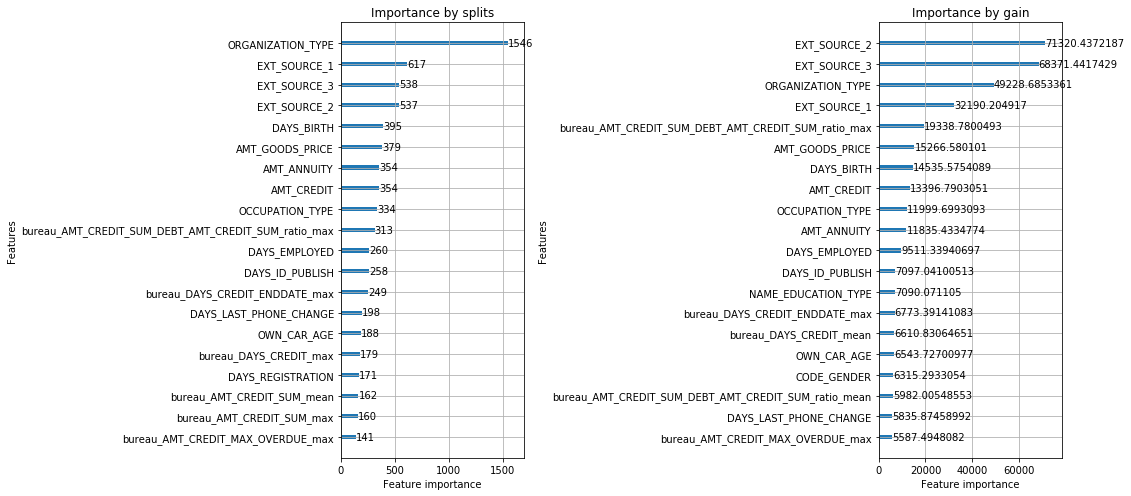

In [20]:
import matplotlib.pyplot as plt

fig, (ax, ax1) = plt.subplots(1, 2, figsize=[15, 7])
lgbm.plot_importance(clf, ax=ax, max_num_features=20, importance_type='split')
lgbm.plot_importance(clf, ax=ax1, max_num_features=20, importance_type='gain')
ax.set_title('Importance by splits')
ax1.set_title('Importance by gain')
plt.tight_layout()
plt.show()

In [38]:
x = [x for x in zip(clf.feature_name(), clf.feature_importance('gain'))]
x.sort(key=lambda x: x[1], reverse=True)
x

[('EXT_SOURCE_2', 71320.437218666077),
 ('EXT_SOURCE_3', 68371.441742897034),
 ('ORGANIZATION_TYPE', 49228.685336112976),
 ('EXT_SOURCE_1', 32190.204916954041),
 ('bureau_AMT_CREDIT_SUM_DEBT_AMT_CREDIT_SUM_ratio_max', 19338.780049324036),
 ('AMT_GOODS_PRICE', 15266.580101013184),
 ('DAYS_BIRTH', 14535.575408935547),
 ('AMT_CREDIT', 13396.790305137634),
 ('OCCUPATION_TYPE', 11999.69930934906),
 ('AMT_ANNUITY', 11835.433477401733),
 ('DAYS_EMPLOYED', 9511.3394069671631),
 ('DAYS_ID_PUBLISH', 7097.0410051345825),
 ('NAME_EDUCATION_TYPE', 7090.0711050033569),
 ('bureau_DAYS_CREDIT_ENDDATE_max', 6773.3914108276367),
 ('bureau_DAYS_CREDIT_mean', 6610.8306465148926),
 ('OWN_CAR_AGE', 6543.7270097732544),
 ('CODE_GENDER', 6315.2933053970337),
 ('bureau_AMT_CREDIT_SUM_DEBT_AMT_CREDIT_SUM_ratio_mean', 5982.005485534668),
 ('DAYS_LAST_PHONE_CHANGE', 5835.8745899200439),
 ('bureau_AMT_CREDIT_MAX_OVERDUE_max', 5587.4948081970215),
 ('bureau_DAYS_CREDIT_max', 5359.0618104934692),
 ('bureau_AMT_CREDI

In [39]:
x = [x for x in zip(clf.feature_name(), clf.feature_importance('split'))]
x.sort(key=lambda x: x[1], reverse=True)
x

[('ORGANIZATION_TYPE', 1546),
 ('EXT_SOURCE_1', 617),
 ('EXT_SOURCE_3', 538),
 ('EXT_SOURCE_2', 537),
 ('DAYS_BIRTH', 395),
 ('AMT_GOODS_PRICE', 379),
 ('AMT_CREDIT', 354),
 ('AMT_ANNUITY', 354),
 ('OCCUPATION_TYPE', 334),
 ('bureau_AMT_CREDIT_SUM_DEBT_AMT_CREDIT_SUM_ratio_max', 313),
 ('DAYS_EMPLOYED', 260),
 ('DAYS_ID_PUBLISH', 258),
 ('bureau_DAYS_CREDIT_ENDDATE_max', 249),
 ('DAYS_LAST_PHONE_CHANGE', 198),
 ('OWN_CAR_AGE', 188),
 ('bureau_DAYS_CREDIT_max', 179),
 ('DAYS_REGISTRATION', 171),
 ('bureau_AMT_CREDIT_SUM_mean', 162),
 ('bureau_AMT_CREDIT_SUM_max', 160),
 ('bureau_AMT_CREDIT_MAX_OVERDUE_max', 141),
 ('bureau_AMT_CREDIT_SUM_DEBT_AMT_CREDIT_SUM_ratio_std', 136),
 ('AMT_INCOME_TOTAL', 133),
 ('bureau_AMT_CREDIT_MAX_OVERDUE_mean', 132),
 ('CODE_GENDER', 131),
 ('bureau_AMT_CREDIT_SUM_DEBT_AMT_CREDIT_SUM_ratio_mean', 124),
 ('bureau_DAYS_CREDIT_UPDATE_max', 123),
 ('bureau_AMT_CREDIT_SUM_min', 120),
 ('REGION_POPULATION_RELATIVE', 119),
 ('bureau_DAYS_CREDIT_mean', 110),
 ('bu